In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the model and tokenizer from Hugging Face
model_name = "monologg/bert-base-cased-goemotions-original"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", 
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", 
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", 
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    scores = torch.softmax(outputs.logits, dim=1)
    top_emotion_index = torch.argmax(scores, dim=1).item()
    return emotion_labels[top_emotion_index]



c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\charu\.cache\huggingface\hub\models--monologg--bert-base-cased-goemotions-original. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or

Predicted Emotion: joy


In [4]:
text = "do you really want to go their, its a bad idea"
predicted_emotion = predict_emotion(text)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: curiosity


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import os

# Model name from Hugging Face
model_name = "monologg/bert-base-cased-goemotions-original"
save_directory = "saved_goemotions_model"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Save the model and tokenizer
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"✅ Model saved to '{save_directory}'")

# Emotion labels from GoEmotions dataset
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", 
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", 
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", 
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

# Function to load the model and predict emotions
def predict_emotion(text, model_dir):
    # Load saved model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)

    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Predict emotion
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Apply softmax to get probabilities
    scores = torch.softmax(outputs.logits, dim=1)
    top_emotion_index = torch.argmax(scores, dim=1).item()
    
    return emotion_labels[top_emotion_index]


c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Model saved to 'saved_goemotions_model'


In [6]:
# Test with a sample sentence
text = "he got into an accident. it s really bad. they are taking him to hospital"
predicted_emotion = predict_emotion(text, save_directory)
print(f" Predicted Emotion: {predicted_emotion}")


 Predicted Emotion: sadness


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Define Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained Tokenizer and Model
model_name = "monologg/bert-base-cased-goemotions-original"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=28)  # GoEmotions has 28 labels
model.to(device)

# Load Dataset (Replace with actual dataset file)
df = pd.read_csv("combined_emotion.csv")  # Ensure CSV has 'sentence' and 'emotion' columns

# Encode Labels
label_encoder = LabelEncoder()
df["emotion"] = label_encoder.fit_transform(df["emotion"])  # Convert text labels to numbers

# Split Dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["sentence"].tolist(), df["emotion"].tolist(), test_size=0.2, random_state=42
)

# Tokenization Function
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Define PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize_texts(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# Create DataLoaders
train_dataset = EmotionDataset(train_texts, train_labels)
val_dataset = EmotionDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch, labels in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={train_acc:.4f}")

# Save Fine-Tuned Model
model.save_pretrained("fine_tuned_goemotions")
tokenizer.save_pretrained("fine_tuned_goemotions")
print("✅ Fine-tuned model saved!")

# Evaluate on Validation Set
model.eval()
val_correct, val_total = 0, 0
with torch.no_grad():
    for batch, labels in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = labels.to(device)
        outputs = model(**batch)
        val_correct += (outputs.logits.argmax(1) == labels).sum().item()
        val_total += labels.size(0)

val_acc = val_correct / val_total
print(f"Validation Accuracy: {val_acc:.4f}")


Classification Report:

              precision    recall  f1-score   support

   annoyance       1.00      1.00      1.00         1
        love       1.00      1.00      1.00         1
     sadness       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



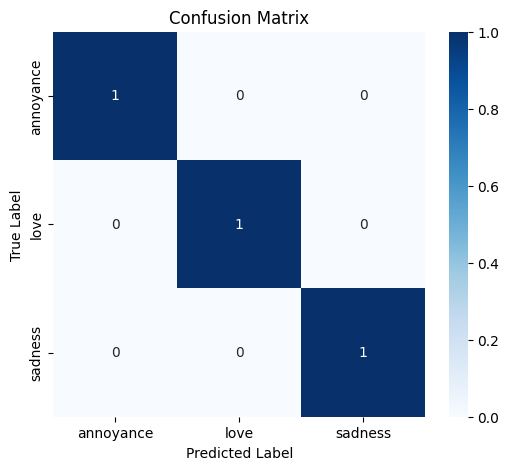

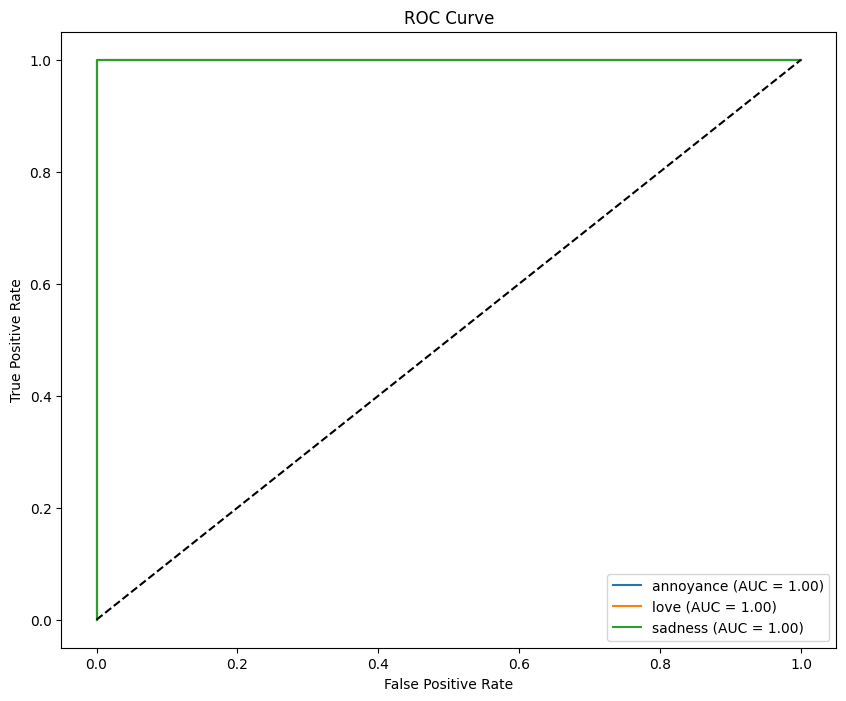

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load Pretrained Model & Tokenizer
model_dir = "saved_goemotions_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

# Emotion Labels from GoEmotions dataset
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", 
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", 
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism", 
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

# Function to predict emotions for multiple texts
def predict_emotions(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    
    scores = torch.softmax(outputs.logits, dim=1)
    y_pred = torch.argmax(scores, dim=1).numpy()  # Predicted class indices
    return y_pred, scores.numpy()  # Return both predictions & probabilities

# Load test dataset (Replace with actual test data)
test_texts = ["I love this!", "This is so annoying!", "I feel sad today."]  # Example texts
true_labels = [18, 3, 25]  # Corresponding true labels (joy, annoyance, sadness)

# Predict emotions
y_pred, y_pred_proba = predict_emotions(test_texts)

# **Get only relevant labels in test set**
unique_classes = np.unique(true_labels)
relevant_emotion_labels = [emotion_labels[i] for i in unique_classes]

# **1. Classification Report (Precision, Recall, F1-score)**
print("\nClassification Report:\n")
print(classification_report(true_labels, y_pred, target_names=relevant_emotion_labels))

# **2. Confusion Matrix**
conf_matrix = confusion_matrix(true_labels, y_pred, labels=unique_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=relevant_emotion_labels, yticklabels=relevant_emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **3. ROC Curve and AUC Score (for Multi-class)**
plt.figure(figsize=(10, 8))
for i, class_index in enumerate(unique_classes):
    fpr, tpr, _ = roc_curve(np.array(true_labels) == class_index, y_pred_proba[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{emotion_labels[class_index]} (AUC = {roc_auc:.2f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
